## Project 4: Titanic Survival Exploration with Decision Trees

### Getting Started
In the introductory [Project 0](https://github.com/nombreinvicto/MachineLearning/tree/master/Project0_TitanicSurvival), 
we studied the Titanic survival data, and were able to make 
predictions about passenger survival. In that project, we built a 
decision tree by hand, that at each stage, picked the features that
were most correlated with survival. This is exactly 
how decision trees work! In this project, we'll do this much quicker 
by implementing a decision tree in sklearn.

We'll start by loading the dataset and displaying some of its rows.

In [37]:
# Import libraries necessary for this project
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
# Pretty display for notebooks
%matplotlib inline

# Set a random seed
random.seed(42)

# Load the dataset
in_file = 'titanic_data.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head(2))

# this function will help us plot learning curves for chosen models

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Recall that these are the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  

In [38]:
# Store the 'Survived' feature in a new variable and remove it from the dataset

outcomes = full_data['Survived']
features_raw = full_data.drop('Survived', axis = 1)

# we will also drop the name feature column since we dont expect 
# the outcome of survival to be too much dependant on the name of a
# person. Likewise we will also remove the ticket number column

features_raw.drop('Name', axis=1, inplace=True)
features_raw.drop('Ticket', axis=1, inplace=True)

# Show the new dataset with 'Survived' removed
display(features_raw.head(2))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,female,38.0,1,0,71.2833,C85,C


The very same sample of the RMS Titanic data now shows the **Survived** feature removed from the DataFrame. Note that `data` (the passenger data) and `outcomes` (the outcomes of survival) are now *paired*. That means for any passenger `data.loc[i]`, they have the survival outcome `outcomes[i]`.

### Preprocessing the data

Now, let's do some data preprocessing. First, we'll one-hot encode the features.

In [39]:
features = pd.get_dummies(features_raw)

And now we'll fill in any blanks with zeroes.

In [40]:
features = features.fillna(0.0)
display(features.head())

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,Cabin_A14,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,3,26.0,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Training the model

Now we're ready to train a model in sklearn. First, let's split the data into training and testing sets. Then we'll train the model on the training set.

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(features, 
                                                outcomes, 
                                                test_size=0.2, 
                                                random_state=42)

In [42]:
# create an unoptimised instance of the tree classifier

model = DecisionTreeClassifier()
model.fit(xtrain,ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Testing the model
Now, let's see how our model does, let's calculate the accuracy over both the training and the testing set.

In [43]:
# Making predictions

ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

# Calculate the accuracy

train_accuracy = accuracy_score(ytrain, ytrain_pred)
test_accuracy = accuracy_score(ytest, ytest_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 1.0
The test accuracy is 0.776536312849162


The output from the cell above shows a 100% accuracy of the model 
on the training dataset whereas only 78% accuracy on the testing 
dataset. This shows the evidence of a highly overfit model on the 
training dataset. We thus need to find a decision tree model with 
optimised hyperparameters that will yield a model that generalises 
to testing data well. However, before finding an optimised model, 
let us observe the learning curve of the unoptimised model.

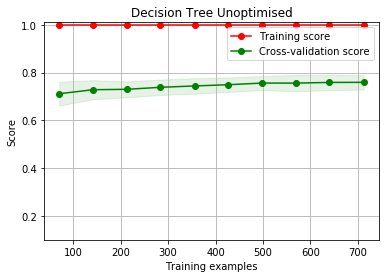

In [44]:
# plot learning curve of unoptimised SVM model

title = r"Decision Tree Unoptimised"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(model, title, features, outcomes, 
                    ylim=(0.1, 1.01),
                    cv=cv, 
                    n_jobs=4)
plt.show()

### Improving the model

From the learning curve above, it can be seen that the training and
 cross validation scores never converge at higher training data 
 sizes and this is a clear testimony to the fact that the model is 
 sufficiently overtrained. Below, we will optimise a decision tree 
 model hyperparameters using GridSearch and will focus on the 
 following 3 hyperparameters.

- `max_depth`
- `min_samples_leaf`
- `min_samples_split`

In [45]:
scoring_func = make_scorer(recall_score)
parameters = {
              'max_depth':range(1, 11, 1), 
              'min_samples_leaf': range(2,11, 1),
              'min_samples_split': range(2,11, 1),
              
              
              }
xtrain, xtest, ytrain, ytest = train_test_split(features, 
                                                    outcomes, 
                                                    test_size=0.2, 
                                                    random_state=42)
cv_sets = ShuffleSplit(n_splits=10
                    , test_size=0.25, 
                      random_state=42)
kf = KFold(n_splits=100, shuffle=True, random_state=42)

model = DecisionTreeClassifier()
grid = GridSearchCV(model, param_grid=parameters, 
                    scoring=scoring_func, 
                    cv=kf, 
                    n_jobs=-1,
                    verbose=4);
grid.fit(features, outcomes);
best_estimator = grid.best_estimator_
best_estimator

Fitting 100 folds for each of 810 candidates, totalling 81000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 5492 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 14102 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 26072 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 41542 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 60372 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 81000 out of 81000 | elapsed:  2.5min finished
/home/mhasan3/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [46]:
ytrain_pred = best_estimator.predict(xtrain)
ytest_pred = best_estimator.predict(xtest)

print(f'Accuracy score of optimised model on training set: '
      f'{accuracy_score(ytrain, ytrain_pred)}')
print(f'Accuracy score of optimised model on testing set: '
      f'{accuracy_score(ytest, ytest_pred)}')

Accuracy score of optimised model on training set: 0.875
Accuracy score of optimised model on testing set: 0.9106145251396648


It can be seen from the output cell above that the optimised model 
has a `max_depth=8`, `min_samples_leaf=5` and 
`min_samples_split=5`. With these hyperparameter values, the training 
accuracy is now 87.85 and the testing accuracy is now an impressive 91.1%.
Additionally, we plot the learning curve of the optimised model below and as 
expected, we observe that the training scores and the cross validation scores
to eventually converge at larger training dataset sizes, showing a model that
generalises well to testing data.

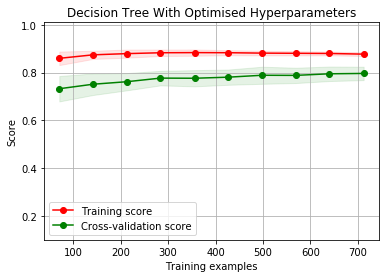

In [47]:
# plot learning curve of unoptimised SVM model
title = r"Decision Tree With Optimised Hyperparameters"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(best_estimator, title, features, outcomes, 
                    ylim=(0.1, 1.01),
                    cv=cv, 
                    n_jobs=4)
plt.show()